In [1]:
import gc
import gzip
import json
import os
import pickle
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm


def reseed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

reseed()

INPUT_FOLDER = '../input/carplates/data/data/'

def make_crop(image, mask, points, offset, crop_w, crop_h, rect):
    l, t, r, b = rect
    h, w = b-t, r-l
    offset = offset - np.array([l, t])
    if points is not None:
        points = [pts - np.array([l, t]) for pts in points]
    
    scale = min(crop_h/h, crop_w/w)
    image = cv2.resize(image[t:b, l:r], None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    offset = offset*scale
    if points is not None:
        mask = cv2.resize(mask[t:b, l:r], None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        points = [pts*scale for pts in points]

    h, w, _ = image.shape
    dy = (crop_h-h) // 2
    dx = (crop_w-w) // 2

    img = np.zeros((crop_h, crop_w, 3), dtype=np.uint8)
    img[dy:dy + image.shape[0], dx:dx + image.shape[1], :] = image
    if points is not None:
        msk = np.zeros((crop_h, crop_w), dtype=np.uint8)
        msk[dy:dy + image.shape[0], dx:dx + image.shape[1]] = mask[:,:,0]
        points = [pts + np.array([dx,dy]) for pts in points]
    offset = offset + np.array([dx, dy])
    return img, msk, points, offset, scale


def make_crops(image, mask, points, offset, crop_w, crop_h):
    ratio = crop_w/crop_h
    h, w, _ = image.shape
    
    result = []
    if h*ratio < 0.8*w:
        ww = int(h*ratio)
        n = w//ww
        d = (w-ww)//n
        for i in range(n+1):
            result.append(make_crop(image, mask, points, offset, crop_w, crop_h, (i*d,0,i*d+ww,h)))
    elif h*ratio > 1.3*w:
        hh = int(w/ratio)
        n = h//hh
        d = (h-hh)//n
        for i in range(n+1):
            result.append(make_crop(image, mask, points, offset, crop_w, crop_h, (0,i*d,w,i*d+hh)))
    else:
        result.append(make_crop(image, mask, points, offset, crop_w, crop_h, (0,0,w,h)))
    
    return result

def convert_train(result_size_x=192, result_size_y=144, return_samples=16):
    ratio = result_size_x/result_size_y
    ##########################################################
    # Load metadata
    ##########################################################
    train = json.load(open(os.path.join(INPUT_FOLDER, 'train.json')))[:-1]  # last image is broken

    ##########################################################
    # Load and transform images
    ##########################################################
    images = []
    masks = []
    boxes = []
    texts = []
    filenames = []
    dxs = []
    dys = []
    scales = []
    for idx, data in tqdm.tqdm(enumerate(train), total=len(train)):
        image = cv2.imread(os.path.join(INPUT_FOLDER, data['file']))
        image = image[..., ::-1]
        mask = np.zeros_like(image)
        points = []
        txts = []
        for box in data['nums']:
            pts = np.array(box['box'], dtype=np.int32)
            mask = cv2.fillPoly(mask, [pts.reshape((-1, 1, 2))], (255, 255, 255))
            txts.append(box['text'])
            points.append(pts.astype(np.float32))

        # remove blackbox
        left = 0
        top = 0
        bottom, right, _ = image.shape
        while left < right and image[:, left].max() < 10:
            left += 1
        while left < right and image[:, right - 1].max() < 10:
            right -= 1
        while top < bottom and image[top, :].max() < 10:
            top += 1
        while top < bottom and image[bottom - 1, :].max() < 10:
            bottom -= 1
        image = image[top:bottom, left:right]
        mask = mask[top:bottom, left:right]
        offset = np.array([-left, -top], dtype=np.float32)
        points = [pts + offset for pts in points]
        
        crops = make_crops(image, mask, points, offset, result_size_x, result_size_y)
        for image, mask, points, offset, scale in crops:
            images.append(torch.tensor(image).permute(2, 0, 1))
            masks.append(torch.tensor(mask))
            boxes.append(points)
            texts.append(txts)
            filenames.append(data['file'])
            dxs.append(offset[0])
            dys.append(offset[1])
            scales.append(scale)
    
    images = torch.stack(images)
    masks = torch.stack(masks)
    ##########################################################
    # Save transformed images and metadata
    ##########################################################
    gc.collect()
    with gzip.open('images.pth', 'wb', 5) as f:
        pickle.dump(images, f)
    with gzip.open('masks.pth', 'wb', 5) as f:
        pickle.dump(masks, f)
    with gzip.open('meta.pickle', 'wb', 5) as f:
        pickle.dump((boxes, texts, filenames, (np.array(dxs), np.array(dys), np.array(scales))), f)
    with gzip.open('images_sample.pth', 'wb', 5) as f:
        pickle.dump(images[:256].clone(), f)
    with gzip.open('masks_sample.pth', 'wb', 5) as f:
        pickle.dump(masks[:256].clone(), f)
    with gzip.open('meta_sample.pickle', 'wb', 5) as f:
        pickle.dump((boxes[:256], texts[:256], filenames[:256], (np.array(dxs[:256]), np.array(dys[:256]), np.array(scales[:256]))), f)

    ##########################################################
    # Prepare samples
    ##########################################################
    if return_samples:
        indices = np.random.choice(images.shape[0], size=return_samples, replace=False)
        return images[indices].permute(0, 2, 3, 1).numpy(), masks[indices].numpy(), [boxes[i] for i in indices]

images, masks, boxes = convert_train()

100%|██████████| 25632/25632 [17:55<00:00, 23.83it/s]
/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


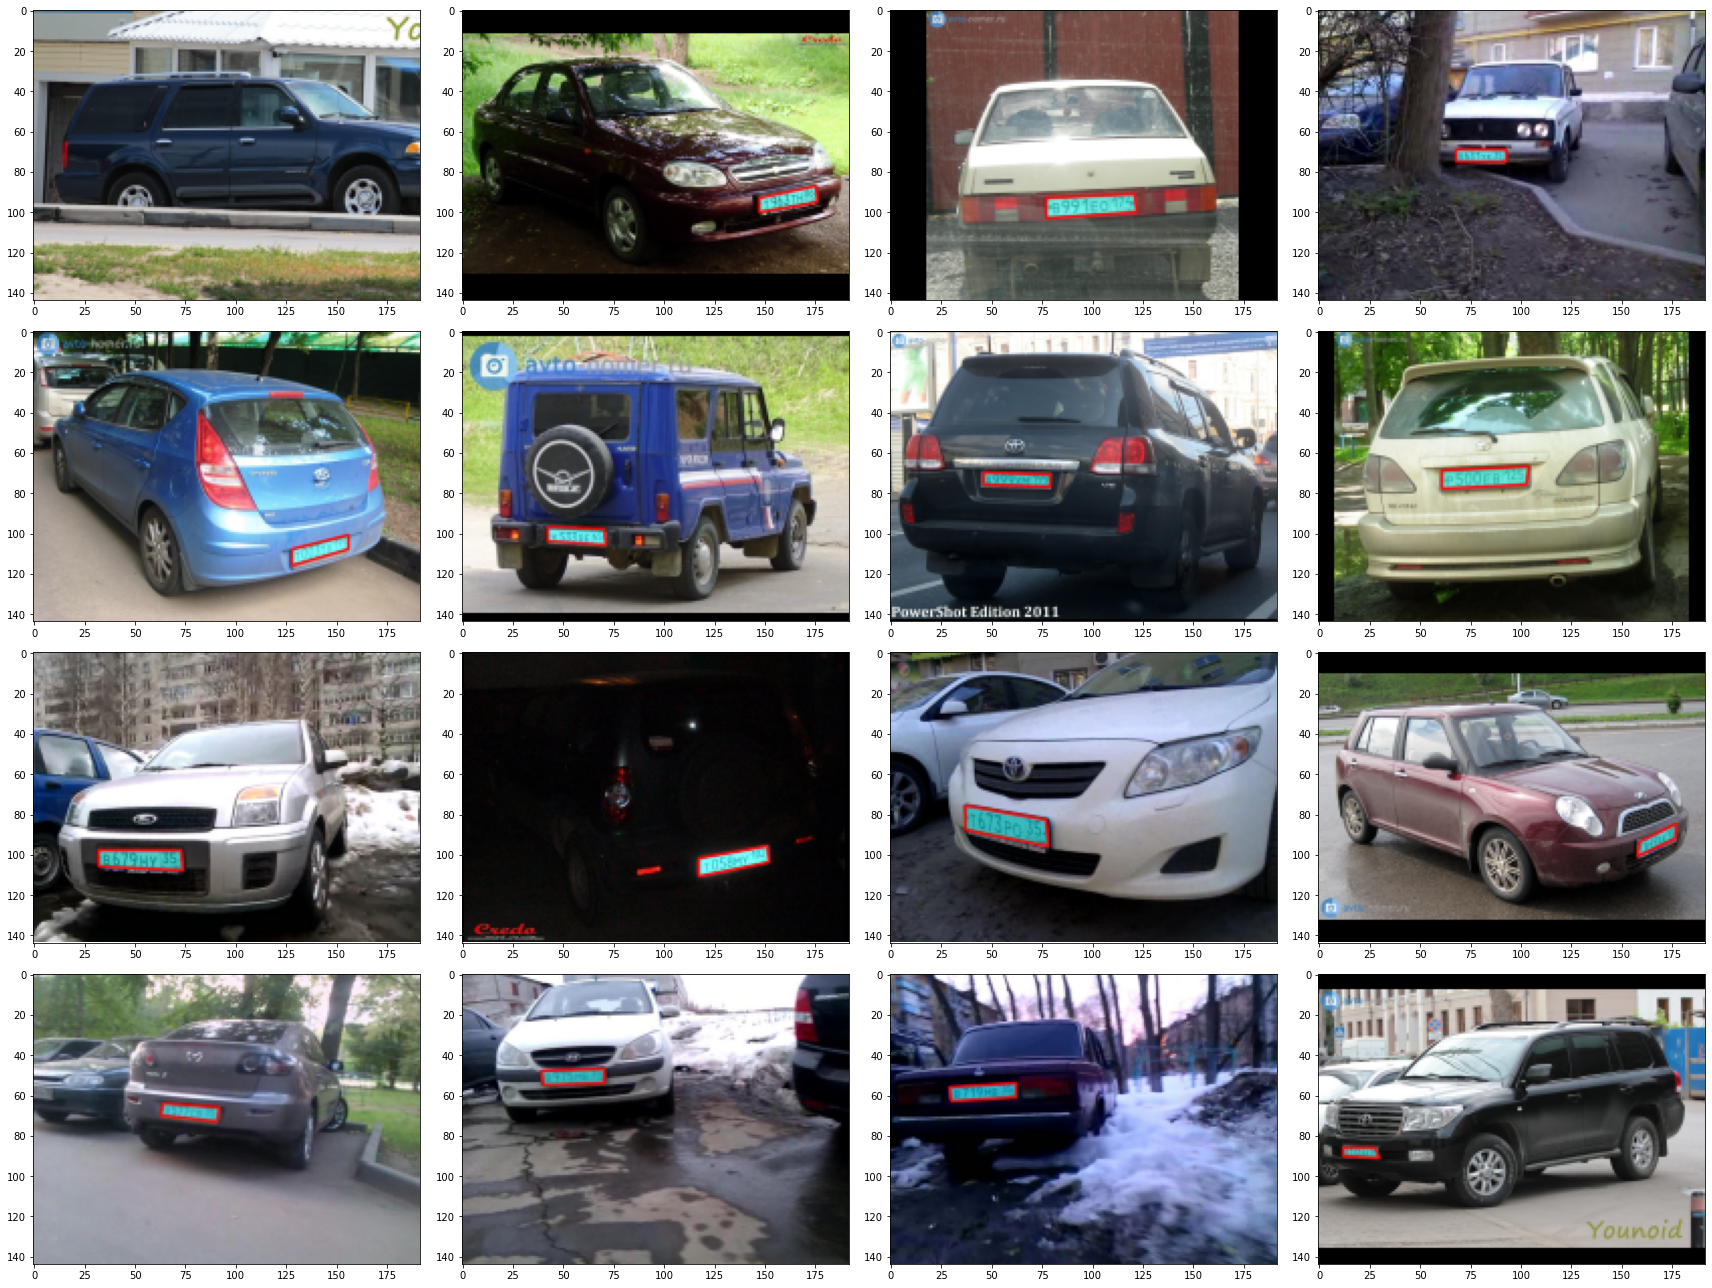

In [2]:
def draw_train_images(images, masks, boxes, rows=4):
    cols = len(images) // rows
    plt.figure(figsize=(24, rows * 18 / cols))
    for i, (image, mask, points) in enumerate(zip(images, masks, boxes)):
        image = (image * (1 - mask[:,:,None] / 512.0) + np.stack((np.zeros_like(mask), mask // 2, mask // 2), axis=2)).astype(np.uint8)
        for pts in points:
            image = cv2.polylines(cv2.UMat(image), [pts.astype(np.int32).reshape(-1,1,2)], True, (255, 0, 0), lineType=cv2.LINE_AA)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.UMat.get(image))
    plt.tight_layout()
    plt.show()

draw_train_images(images, masks, boxes, rows=4)

In [3]:
!ls -l

total 1775772
---------- 1 root root       7364 Jun 18 20:25 __notebook__.ipynb
-rw-r--r-- 1 root root 1795252743 Jun 18 20:45 images.pth
-rw-r--r-- 1 root root   16642165 Jun 18 20:45 images_sample.pth
-rw-r--r-- 1 root root    4222512 Jun 18 20:45 masks.pth
-rw-r--r-- 1 root root      40494 Jun 18 20:45 masks_sample.pth
-rw-r--r-- 1 root root    2184636 Jun 18 20:45 meta.pickle
-rw-r--r-- 1 root root      22677 Jun 18 20:45 meta_sample.pickle
